In [1]:
import pandas as pd 
import numpy as np
import os
dataset_folder = '../dataset_new'

In [2]:
sensors = ['sensor2', 'sensor3', 'sensor4','sensor7','sensor8','sensor9','sensor11','sensor12','sensor13','sensor14',
           'sensor15','sensor17','sensor20', 'sensor21']

In [3]:
train = []
files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('scaled')]

for file in files: 
    path_to_file = dataset_folder + '/'+file
    df = pd.read_csv(path_to_file, index_col=0) #index_col = 0 perché sennò viene aggiunta la colonna unnamed. 
    train.append(df)

train[0].head()

,unit_number,time_cycle,op_setting1,op_setting2,op_setting3,RUL,sensor2,sensor3,sensor4,sensor6,...,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,1.0,-0.0007,-0.0004,100.0,191.0,0.183735,0.406802,0.309757,1.0,...,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1.0,2.0,0.0019,-0.0003,100.0,190.0,0.283133,0.453019,0.352633,1.0,...,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1.0,3.0,-0.0043,0.0003,100.0,189.0,0.343373,0.369523,0.370527,1.0,...,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1.0,4.0,0.0007,0.0000,100.0,188.0,0.343373,0.256159,0.331195,1.0,...,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1.0,5.0,-0.0019,-0.0002,100.0,187.0,0.349398,0.257467,0.404625,1.0,...,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


La seguente funzione *process_targets* è la cosiddetta funzione **lineare a tratti** di cui parliamo estensivamente all'interno del readme ci permette dunque di calcolare il valore della RUL da assegnare ad ogni elemento del dataset. 
La funzione prende in input la lunghezza totale dei dati e la *"early_rul"* la quale rappresenta il valore massimo possibile di RUL (imponiamo ciò poiché come descritto dalla letteratura dovrebbe permettere alla rete di comprendere meglio quando il componente è in salute o meno), il quale poi viene decrementato in maniera lineare quando la *"data_length"* supera il valore di *early_rul*

In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

*process_input_data_with_targets* è invece la funzione addetta a "sistemare" i valori all'interno delle loro proprie sequenze di *window_length* valori. 

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [6]:
#Configurazione

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []

FD0001 = train[0]
unit_number_col = FD0001['unit_number']
num_train_machines_FD0001 = len(FD0001['unit_number'].unique())
FD0001 = FD0001[sensors]

In [7]:
new_FD0001 = pd.concat([unit_number_col, FD0001], axis= 1 )

In [8]:
new_FD0001.head()

,unit_number,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1.0,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1.0,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1.0,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1.0,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


In [9]:

for i in np.arange(1, num_train_machines_FD0001 + 1):
    temp_train_data = new_FD0001[new_FD0001['unit_number'] == i].drop(columns = ['unit_number']).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [10]:

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=42)

In [12]:
from keras import backend as K 
import tensorflow as tf 
import math 

@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum


2023-11-09 20:00:14.416920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 20:00:14.416951: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 20:00:14.416969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 20:00:14.424115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


#Replica della rete neurale proposta come "small LSTM"
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score] )
    return model


In [14]:
LSTMsmallModel = createLSTMsmallModel(60, 30, 30, 15, (30, 14)) 

2023-11-09 20:00:16.513785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 20:00:16.521162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 20:00:16.521224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 20:00:16.524794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 20:00:16.524860: I tensorflow/compile

In [15]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20 :
        return 0.001
    elif epoch >= 20 and epoch < 30: 
        return 0.0001
    elif epoch >= 30: 
        return 0.00001
    else: 
        return 0.01; 
    

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 50 #100 / 80 / 150 

path_small = './models/LSTMsmall/FD0001_scoreFixed'



model_checkpoint = ModelCheckpoint(
    path_small,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)


early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)



In [17]:
history = LSTMsmallModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = EPOCHS,
    batch_size = 256,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50


2023-11-09 20:00:21.359935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 20:00:22.667101: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faf200a59e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-09 20:00:22.667135: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-11-09 20:00:22.672841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-09 20:00:22.750155: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/56 [===========================>..] - ETA: 0s - loss: 1392.3428 - custom_score: 91313.2656
Epoch 1: val_loss improved from inf to 675.55524, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 12s 130ms/step - loss: 1374.3390 - custom_score: 88254.7031 - val_loss: 675.5552 - val_custom_score: 13175.5625 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
53/56 [===========================>..] - ETA: 0s - loss: 503.1531 - custom_score: 5095.1865
Epoch 2: val_loss improved from 675.55524 to 375.50388, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 7s 122ms/step - loss: 499.7245 - custom_score: 4965.7524 - val_loss: 375.5039 - val_custom_score: 3214.0347 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
54/56 [===========================>..] - ETA: 0s - loss: 344.2805 - custom_score: 2521.1755
Epoch 3: val_loss improved from 375.50388 to 215.01143, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 112ms/step - loss: 340.6245 - custom_score: 2455.8459 - val_loss: 215.0114 - val_custom_score: 1074.0671 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
54/56 [===========================>..] - ETA: 0s - loss: 225.6767 - custom_score: 1215.9904
Epoch 4: val_loss did not improve from 215.01143
56/56 [==============================] - 1s 16ms/step - loss: 224.3592 - custom_score: 1193.9756 - val_loss: 230.3035 - val_custom_score: 817.0491 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/50
56/56 [==============================] - ETA: 0s - loss: 184.3634 - custom_score: 886.9828
Epoch 5: val_loss improved from 215.01143 to 202.57082, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 5s 99ms/step - loss: 184.3634 - custom_score: 886.9828 - val_loss: 202.5708 - val_custom_score: 751.0582 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 6/50
54/56 [===========================>..] - ETA: 0s - loss: 175.2463 - custom_score: 855.2010
Epoch 6: val_loss improved from 202.57082 to 195.76671, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 105ms/step - loss: 175.1656 - custom_score: 842.2061 - val_loss: 195.7667 - val_custom_score: 1239.8763 - lr: 0.0100

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 7/50
53/56 [===========================>..] - ETA: 0s - loss: 172.2659 - custom_score: 861.7494
Epoch 7: val_loss improved from 195.76671 to 165.46719, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 105ms/step - loss: 172.1857 - custom_score: 852.0037 - val_loss: 165.4672 - val_custom_score: 835.9960 - lr: 0.0100

Epoch 8: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 8/50
53/56 [===========================>..] - ETA: 0s - loss: 174.9030 - custom_score: 887.9715
Epoch 8: val_loss did not improve from 165.46719
56/56 [==============================] - 1s 15ms/step - loss: 175.4297 - custom_score: 892.5228 - val_loss: 177.6308 - val_custom_score: 689.1735 - lr: 0.0100

Epoch 9: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 9/50
53/56 [===========================>..] - ETA: 0s - loss: 161.1613 - custom_score: 790.8187
Epoch 9: val_loss improved from 165.46719 to 157.82578, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 7s 126ms/step - loss: 160.2147 - custom_score: 776.6458 - val_loss: 157.8258 - val_custom_score: 735.3944 - lr: 0.0100

Epoch 10: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 10/50
56/56 [==============================] - ETA: 0s - loss: 161.4033 - custom_score: 793.4536
Epoch 10: val_loss improved from 157.82578 to 154.14246, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 115ms/step - loss: 161.4033 - custom_score: 793.4536 - val_loss: 154.1425 - val_custom_score: 762.9801 - lr: 0.0100

Epoch 11: LearningRateScheduler setting learning rate to 0.001.
Epoch 11/50
55/56 [============================>.] - ETA: 0s - loss: 147.0810 - custom_score: 718.6887
Epoch 11: val_loss improved from 154.14246 to 151.58644, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 111ms/step - loss: 146.8588 - custom_score: 710.2521 - val_loss: 151.5864 - val_custom_score: 743.6772 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.001.
Epoch 12/50
56/56 [==============================] - ETA: 0s - loss: 145.5746 - custom_score: 704.7689
Epoch 12: val_loss did not improve from 151.58644
56/56 [==============================] - 1s 18ms/step - loss: 145.5746 - custom_score: 704.7689 - val_loss: 151.6659 - val_custom_score: 694.6060 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.001.
Epoch 13/50
55/56 [============================>.] - ETA: 0s - loss: 145.8720 - custom_score: 715.8660
Epoch 13: val_loss did not improve from 151.58644
56/56 [==============================] - 1s 16ms/step - loss: 145.7708 - custom_score: 707.7809 - val_loss: 151.6724 - val_custom_score: 732.0176 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.001.
Epoch 14/50
55/56 [==

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 105ms/step - loss: 144.5046 - custom_score: 699.8032 - val_loss: 150.5868 - val_custom_score: 694.7018 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.001.
Epoch 16/50
53/56 [===========================>..] - ETA: 0s - loss: 144.6561 - custom_score: 715.4152
Epoch 16: val_loss improved from 150.58678 to 149.26147, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 105ms/step - loss: 144.6546 - custom_score: 709.8561 - val_loss: 149.2615 - val_custom_score: 739.1970 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.001.
Epoch 17/50
53/56 [===========================>..] - ETA: 0s - loss: 144.0655 - custom_score: 710.3956
Epoch 17: val_loss improved from 149.26147 to 148.48647, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 100ms/step - loss: 144.0585 - custom_score: 700.2420 - val_loss: 148.4865 - val_custom_score: 696.3456 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.001.
Epoch 18/50
53/56 [===========================>..] - ETA: 0s - loss: 143.0425 - custom_score: 708.0985
Epoch 18: val_loss did not improve from 148.48647
56/56 [==============================] - 1s 15ms/step - loss: 142.4579 - custom_score: 696.7252 - val_loss: 150.1997 - val_custom_score: 677.7902 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.001.
Epoch 19/50
54/56 [===========================>..] - ETA: 0s - loss: 143.3483 - custom_score: 711.7315
Epoch 19: val_loss did not improve from 148.48647
56/56 [==============================] - 1s 16ms/step - loss: 143.3210 - custom_score: 708.9145 - val_loss: 150.4665 - val_custom_score: 660.2540 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.001.
Epoch 20/50
55/56 [==

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 106ms/step - loss: 143.7349 - custom_score: 701.7048 - val_loss: 147.2071 - val_custom_score: 720.4183 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0001.
Epoch 21/50
56/56 [==============================] - ETA: 0s - loss: 140.8867 - custom_score: 692.1787
Epoch 21: val_loss did not improve from 147.20709
56/56 [==============================] - 1s 14ms/step - loss: 140.8867 - custom_score: 692.1787 - val_loss: 148.1274 - val_custom_score: 676.6796 - lr: 1.0000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0001.
Epoch 22/50
55/56 [============================>.] - ETA: 0s - loss: 140.7893 - custom_score: 691.4114
Epoch 22: val_loss improved from 147.20709 to 146.73914, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 104ms/step - loss: 140.4873 - custom_score: 682.2051 - val_loss: 146.7391 - val_custom_score: 710.9253 - lr: 1.0000e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0001.
Epoch 23/50
55/56 [============================>.] - ETA: 0s - loss: 140.4914 - custom_score: 699.8096
Epoch 23: val_loss did not improve from 146.73914
56/56 [==============================] - 1s 16ms/step - loss: 140.6114 - custom_score: 692.0262 - val_loss: 147.1735 - val_custom_score: 688.5641 - lr: 1.0000e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0001.
Epoch 24/50
53/56 [===========================>..] - ETA: 0s - loss: 140.3104 - custom_score: 690.4616
Epoch 24: val_loss improved from 146.73914 to 146.55928, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 101ms/step - loss: 140.4435 - custom_score: 685.6844 - val_loss: 146.5593 - val_custom_score: 722.7245 - lr: 1.0000e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0001.
Epoch 25/50
55/56 [============================>.] - ETA: 0s - loss: 140.7533 - custom_score: 700.5013
Epoch 25: val_loss did not improve from 146.55928
56/56 [==============================] - 1s 16ms/step - loss: 140.5667 - custom_score: 692.5026 - val_loss: 147.1153 - val_custom_score: 684.8383 - lr: 1.0000e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0001.
Epoch 26/50
55/56 [============================>.] - ETA: 0s - loss: 140.6028 - custom_score: 695.3701
Epoch 26: val_loss did not improve from 146.55928
56/56 [==============================] - 1s 15ms/step - loss: 140.5473 - custom_score: 687.5712 - val_loss: 147.0125 - val_custom_score: 687.5450 - lr: 1.0000e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0001.
Epoch 

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 109ms/step - loss: 140.2277 - custom_score: 689.2087 - val_loss: 146.5066 - val_custom_score: 694.8889 - lr: 1.0000e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0001.
Epoch 30/50
56/56 [==============================] - ETA: 0s - loss: 140.0670 - custom_score: 693.4343
Epoch 30: val_loss did not improve from 146.50661
56/56 [==============================] - 1s 14ms/step - loss: 140.0670 - custom_score: 693.4343 - val_loss: 148.5527 - val_custom_score: 666.2313 - lr: 1.0000e-04

Epoch 31: LearningRateScheduler setting learning rate to 1e-05.
Epoch 31/50
56/56 [==============================] - ETA: 0s - loss: 140.1999 - custom_score: 665.8536
Epoch 31: val_loss improved from 146.50661 to 146.38570, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 104ms/step - loss: 140.1999 - custom_score: 665.8536 - val_loss: 146.3857 - val_custom_score: 697.2134 - lr: 1.0000e-05

Epoch 32: LearningRateScheduler setting learning rate to 1e-05.
Epoch 32/50
55/56 [============================>.] - ETA: 0s - loss: 139.9110 - custom_score: 696.5056
Epoch 32: val_loss did not improve from 146.38570
56/56 [==============================] - 1s 15ms/step - loss: 139.8556 - custom_score: 689.6475 - val_loss: 146.4173 - val_custom_score: 694.5283 - lr: 1.0000e-05

Epoch 33: LearningRateScheduler setting learning rate to 1e-05.
Epoch 33/50
54/56 [===========================>..] - ETA: 0s - loss: 139.5018 - custom_score: 689.1180
Epoch 33: val_loss improved from 146.38570 to 146.34904, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 105ms/step - loss: 139.8297 - custom_score: 684.5410 - val_loss: 146.3490 - val_custom_score: 696.3840 - lr: 1.0000e-05

Epoch 34: LearningRateScheduler setting learning rate to 1e-05.
Epoch 34/50
52/56 [==========================>...] - ETA: 0s - loss: 140.4935 - custom_score: 702.0846
Epoch 34: val_loss did not improve from 146.34904
56/56 [==============================] - 1s 16ms/step - loss: 139.8627 - custom_score: 691.6234 - val_loss: 146.3887 - val_custom_score: 694.7166 - lr: 1.0000e-05

Epoch 35: LearningRateScheduler setting learning rate to 1e-05.
Epoch 35/50
53/56 [===========================>..] - ETA: 0s - loss: 140.2844 - custom_score: 693.8893
Epoch 35: val_loss did not improve from 146.34904
56/56 [==============================] - 1s 14ms/step - loss: 139.8440 - custom_score: 684.1244 - val_loss: 146.4150 - val_custom_score: 693.5253 - lr: 1.0000e-05

Epoch 36: LearningRateScheduler setting learning rate to 1e-05.
Epoch 36/

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 105ms/step - loss: 139.8002 - custom_score: 687.2609 - val_loss: 146.3282 - val_custom_score: 695.4146 - lr: 1.0000e-05

Epoch 40: LearningRateScheduler setting learning rate to 1e-05.
Epoch 40/50
56/56 [==============================] - ETA: 0s - loss: 139.8022 - custom_score: 685.3978
Epoch 40: val_loss did not improve from 146.32819
56/56 [==============================] - 1s 16ms/step - loss: 139.8022 - custom_score: 685.3978 - val_loss: 146.3544 - val_custom_score: 694.2132 - lr: 1.0000e-05

Epoch 41: LearningRateScheduler setting learning rate to 1e-05.
Epoch 41/50
52/56 [==========================>...] - ETA: 0s - loss: 139.9384 - custom_score: 696.9476
Epoch 41: val_loss improved from 146.32819 to 146.31552, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 5s 97ms/step - loss: 139.7797 - custom_score: 686.1671 - val_loss: 146.3155 - val_custom_score: 695.2902 - lr: 1.0000e-05

Epoch 42: LearningRateScheduler setting learning rate to 1e-05.
Epoch 42/50
54/56 [===========================>..] - ETA: 0s - loss: 139.8546 - custom_score: 693.1238
Epoch 42: val_loss did not improve from 146.31552
56/56 [==============================] - 1s 16ms/step - loss: 139.7748 - custom_score: 685.6219 - val_loss: 146.3315 - val_custom_score: 694.4296 - lr: 1.0000e-05

Epoch 43: LearningRateScheduler setting learning rate to 1e-05.
Epoch 43/50
55/56 [============================>.] - ETA: 0s - loss: 139.9162 - custom_score: 698.6997
Epoch 43: val_loss did not improve from 146.31552
56/56 [==============================] - 1s 15ms/step - loss: 139.7937 - custom_score: 690.7570 - val_loss: 146.5595 - val_custom_score: 687.8265 - lr: 1.0000e-05

Epoch 44: LearningRateScheduler setting learning rate to 1e-05.
Epoch 44/5

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 102ms/step - loss: 139.7561 - custom_score: 678.8527 - val_loss: 146.2734 - val_custom_score: 695.9664 - lr: 1.0000e-05

Epoch 45: LearningRateScheduler setting learning rate to 1e-05.
Epoch 45/50
55/56 [============================>.] - ETA: 0s - loss: 139.4024 - custom_score: 703.9769
Epoch 45: val_loss did not improve from 146.27344
56/56 [==============================] - 1s 16ms/step - loss: 139.8030 - custom_score: 696.7272 - val_loss: 146.5559 - val_custom_score: 687.5665 - lr: 1.0000e-05

Epoch 46: LearningRateScheduler setting learning rate to 1e-05.
Epoch 46/50
53/56 [===========================>..] - ETA: 0s - loss: 140.0224 - custom_score: 692.1985
Epoch 46: val_loss did not improve from 146.27344
56/56 [==============================] - 1s 14ms/step - loss: 139.7568 - custom_score: 685.1709 - val_loss: 146.2805 - val_custom_score: 695.1616 - lr: 1.0000e-05

Epoch 47: LearningRateScheduler setting learning rate to 1e-05.
Epoch 47/

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 100ms/step - loss: 139.7122 - custom_score: 681.4393 - val_loss: 146.2358 - val_custom_score: 695.7281 - lr: 1.0000e-05

Epoch 50: LearningRateScheduler setting learning rate to 1e-05.
Epoch 50/50
55/56 [============================>.] - ETA: 0s - loss: 139.9275 - custom_score: 695.7548
Epoch 50: val_loss improved from 146.23579 to 146.22313, saving model to ./models/LSTMsmall/FD0001_scoreFixed
INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


56/56 [==============================] - 6s 106ms/step - loss: 139.7105 - custom_score: 688.0789 - val_loss: 146.2231 - val_custom_score: 695.9095 - lr: 1.0000e-05


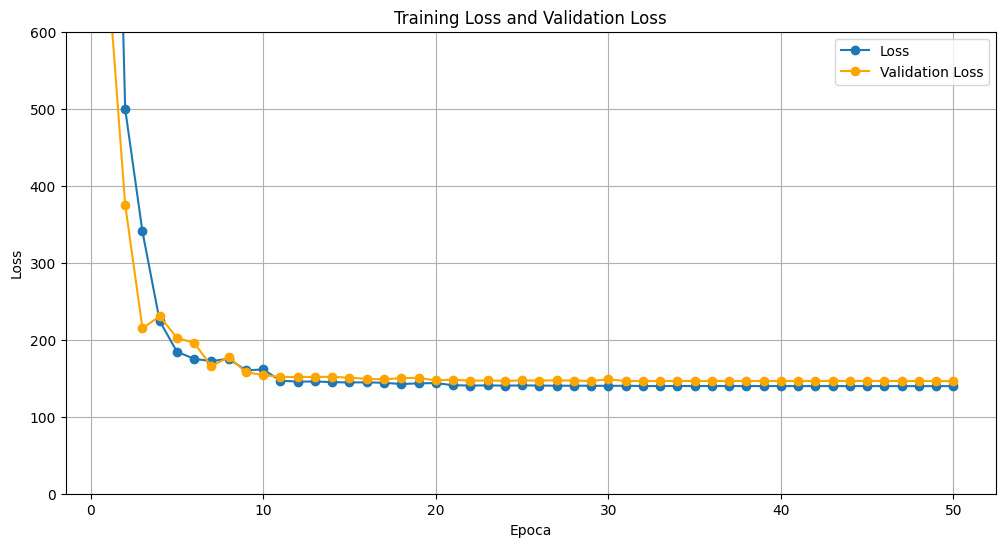

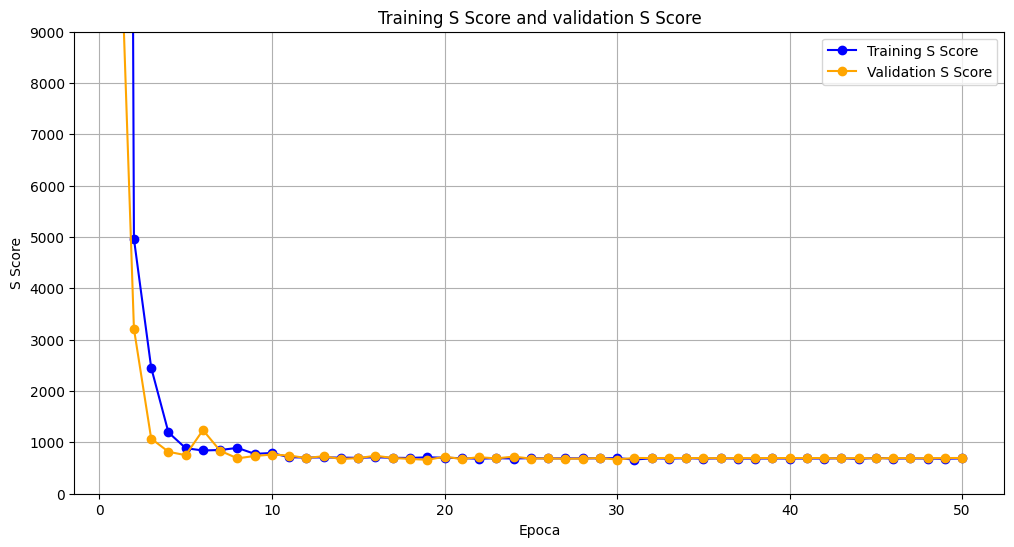

In [18]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']


custom_score_values = history.history['custom_score']  
custom_score_validation_values = history.history['val_custom_score']


# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

# Plot della custom score
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0, 9000)
plt.legend()
plt.grid(True)
plt.show()


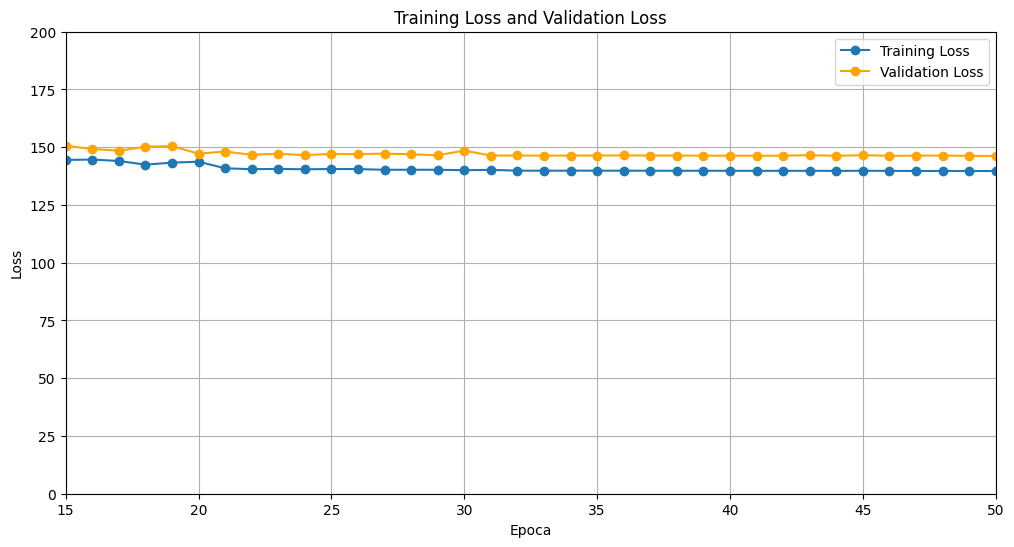

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 200)
plt.xlim(15,50)
plt.legend()
plt.grid(True)
plt.show()


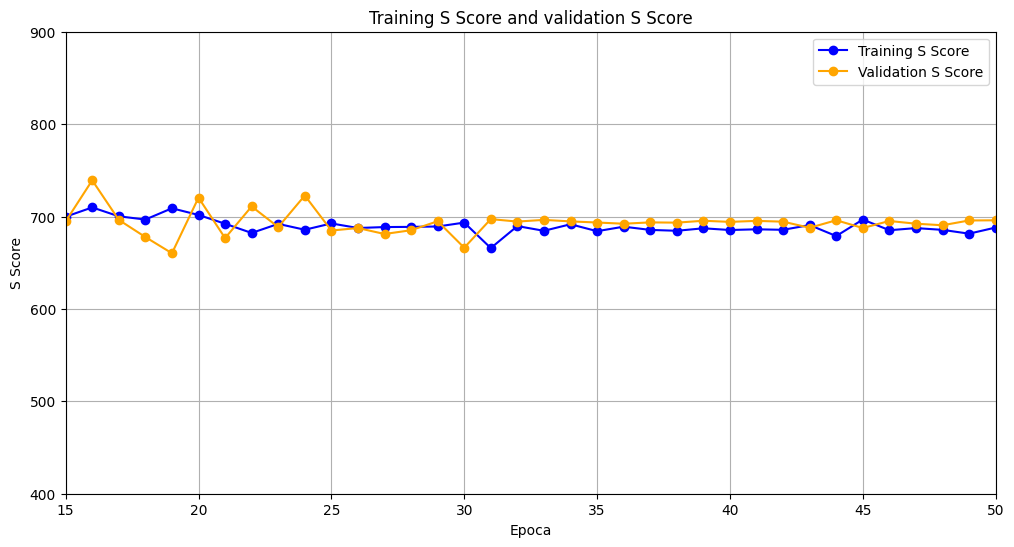

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(400, 900)
plt.xlim(15,50)
plt.legend()
plt.grid(True)
plt.show()

In [21]:
### FUNZIONA
MODEL_DIR = '/home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova'
run_model = tf.function(lambda x: LSTMsmallModel(x))
BATCH_SIZE = 256
STEPS = 30
INPUT_SIZE = 14

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], LSTMsmallModel.inputs[0].dtype)
)
converter = tf.lite.TFLiteConverter.from_keras_model(LSTMsmallModel)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


LSTMsmallModel.save(MODEL_DIR, save_format="tf", signatures = concrete_func )

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

with open("small_lstm_fixed.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova/assets


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova/assets
2023-11-09 20:03:10.986343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-09 20:03:10.986386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-09 20:03:10.986724: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova
2023-11-09 20:03:11.005302: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-09 20:03:11.005332: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova
2023-11-09 20:03:11.044022: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
202

In [23]:
from sklearn.preprocessing import StandardScaler

test_data = pd.read_csv("../../CMAPSS/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD001.txt", sep = "\s+", header = None)

num_test_windows = 5
processed_test_data = []
num_test_windows_list = []
test_data_first_column = test_data[0]


columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data.drop(columns = columns_to_be_dropped))
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

In [24]:
num_test_machines = len(test_data[0].unique())

In [25]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [26]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [27]:
rul_pred = LSTMsmallModel.predict(processed_test_data).reshape(-1)

16/16 [==============================] - 1s 7ms/step


In [28]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

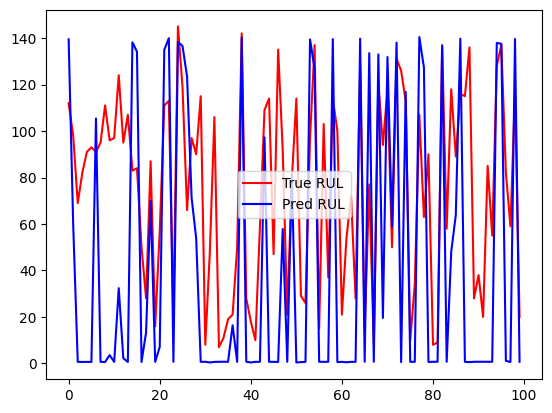

In [29]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [30]:

from sklearn.metrics import mean_squared_error
rul_pred = LSTMsmallModel.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 0s 7ms/step
RMSE:  56.52457122418343
